In [1]:
import matplotlib.pyplot as plt
import copy
import numpy as np
import torch
import cv2
import os
import subprocess
from dataloaders.visual_genome import VGDataLoader
from augment.sg_perturb import SceneGraphPerturb
from augment.bert import BERT
from lib.visualize import * 
from lib.pytorch_misc import set_seed
from lib.word_vectors import obj_edge_vectors
import seaborn as sns
sns.set(color_codes=True)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

print('torch version', torch.__version__)
print('gitcommit', subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD']).decode('ascii').strip())

torch version 1.5.0
gitcommit 723d7ef


# Visualize images, their scene graphs and perturbations

In [3]:
# Load VG data
data_dir = '/scratch/ssd/data'  # root folder where VG and GQA data are located
train_loader, eval_loaders = VGDataLoader.splits(data_dir=data_dir,
                                                 filter_non_overlap=False,
                                                 backbone='vgg16_old')
embed_objs = obj_edge_vectors(train_loader.dataset.ind_to_classes,
                              wv_dir=train_loader.dataset.root,
                              wv_dim=200,
                              avg_words=True)[0]
embed_objs = embed_objs / torch.norm(embed_objs, 2, dim=1, keepdim=True)
bert = BERT(obj_classes=train_loader.dataset.ind_to_classes, 
            rel_classes=train_loader.dataset.ind_to_predicates, 
            triplet2str=train_loader.dataset.triplet2str,
            device='cpu')


Loading the STANFORD split of Visual Genome

TRAIN DATASET
subj_pred_pairs, pred_obj_pairs 3397 3542
57723 images, 405860 triplets (29283 unique triplets)
Stats: 670591 objects (min=2.0, max=62.0, mean=11.6, std=5.8), 297318 FG edges (min=1.0, max=44.0, mean=5.2, std=3.8), 9029910 BG edges (156.44 avg), graph density min=0.0, max=100.0, mean=6.5, std=8.2

VAL DATASET (ZERO-SHOTS)
722 images, 1130 triplets (851 unique triplets)
Stats: 10129 objects (min=2.0, max=44.0, mean=14.0, std=7.6), 1026 FG edges (min=1.0, max=7.0, mean=1.4, std=0.9), 173934 BG edges (240.91 avg), graph density min=0.1, max=50.0, mean=2.4, std=5.3

VAL DATASET (ALL-SHOTS)
5000 images, 33203 triplets (5043 unique triplets)
Stats: 62754 objects (min=2.0, max=52.0, mean=12.6, std=7.1), 25727 FG edges (min=1.0, max=31.0, mean=5.1, std=4.4), 976590 BG edges (195.32 avg), graph density min=0.1, max=100.0, mean=6.1, std=8.7

TEST DATASET (ZERO SHOTS)
4519 images, 7601 triplets (5278 unique triplets)
Stats: 65281 objects

In [ ]:
img_list = [2350517, 2343590, 1159620]  # Used in the paper
# img_list = [2350517, 2343590, 713077, 713094, 713129, 713166, 
#            713410, 713467, 713500, 713504, 713581, 713728, 713785, 713835, 1159494, 1159620]  # More images


save = False  # save images and their graphs to the folder results
results_dir = './results'
if save and not os.path.exists(results_dir):
    os.mkdir(results_dir)

methods = ['rand', 'neigh', 'structn']
alphas = [0, 1, 2, 3, 4, 5, 10, 20, 50]
hit_rates, bert_scores = {}, {}
for split in eval_loaders:
    if split.startswith('test'):
        hit_rates[split.split('_')[1]] = {}
c = 0
n_images_max = 1000  # try more images to reduce noise

for dataset_ind, dataset in enumerate([train_loader.dataset, eval_loaders['test_alls'].dataset]):
    for i, (im_name, gt_classes, gt_rels, boxes) in enumerate(list(zip(dataset.filenames, 
                                                                   dataset.gt_classes, 
                                                                   dataset.relationships,
                                                                   dataset.gt_boxes))):
        name = im_name.split('.')[0]
        vis = int(name) in img_list
        
        if vis:
            im_path = os.path.join(dataset.images_dir, im_name)
            im = cv2.imread(im_path)
            obj_class_names = [dataset.ind_to_classes[cls] for cls in gt_classes]

            im = draw_boxes(im[:,:,::-1], obj_class_names, boxes, fontscale=1, rels=None)
            if save:
                cv2.imwrite('{}/{}.png'.format(results_dir, name), im[:,:,::-1])
            plt.figure(figsize=(7,7))
            plt.imshow(im)
            plt.title((im_path))
            plt.grid(False)
            plt.axis('off')
            plt.show()
        
            show_nx(gt_classes, boxes, gt_rels, 
                    train_set=train_loader.dataset, 
                    test_set=eval_loaders['test_zs'].dataset,
                    name='{}/{}_sg'.format(results_dir, name) if save else None,
                    fontsize=26)
        
        if not vis and c >= n_images_max:
            continue
            
        for method in methods:
            for split in hit_rates:
                if method not in hit_rates[split]:
                    hit_rates[split][method] = {}
                if method not in bert_scores:
                    bert_scores[method] = {}
            
            topk = 10 if method == 'neigh' else 5
            L = 0.5 if vis else 0.2
            
            for alpha in (alphas if method == 'structn' else alphas[:1]):                
                
                for split in hit_rates:
                    if alpha not in hit_rates[split][method]:
                        hit_rates[split][method][alpha] = []
                if alpha not in bert_scores[method]:
                    bert_scores[method][alpha] = []
                                
                sgp = SceneGraphPerturb(method=method,
                                        embed_objs=embed_objs,
                                        subj_pred_obj_pairs=(train_loader.dataset.subj_pred_pairs,
                                                             train_loader.dataset.pred_obj_pairs),
                                        L=L, 
                                        topk=topk, 
                                        alpha=alpha)
                
                for it in range(5 if vis else 1):  # perturb the same graph several times to check diversity
                    
                    if vis:
                        set_seed(it)  # fix to generate the same perturbations                    
                        print('Image={}, Perturbation={}({}), Seed={}'.format(name, method.upper(), alpha, it))
                    
                    gt_cls_pert = sgp.perturb(torch.cat((torch.zeros(len(gt_classes), 1).long(), torch.from_numpy(gt_classes).view(-1, 1)), 1),
                                              torch.cat((torch.zeros(len(gt_rels), 1).long(), torch.from_numpy(gt_rels).view(-1, 3)), 1))[:, 1].data.numpy()
                    perturbed_nodes = np.where(gt_classes != gt_cls_pert)[0]
                    
                    if dataset_ind == 0 and c < n_images_max:
                        # Compute hit rates only for training inputs
                        c_hit = {split: 0 for split in hit_rates}
                        bert_score = []
                        for node in perturbed_nodes:
                            for node1, node2, R in gt_rels:
                                if node in [node1, node2]:
                                    tri = '{}_{}_{}'.format(gt_cls_pert[node1], R, gt_cls_pert[node2])
                                    for split in hit_rates:
                                        if tri in eval_loaders['test_%s' % split].dataset.triplet_counts:
                                            c_hit[split] += 1
                                    bert_score.append(bert.bert_score_triplet(tri, gt_cls_pert, gt_rels, 
                                                                              node == node1, verbose=False))
                                    
                                    

                        if len(bert_score) > 0:
                            for split in hit_rates:
                                hit_rates[split][method][alpha].append(c_hit[split] / len(bert_score))
                            bert_scores[method][alpha].append(np.mean(bert_score))

                    if vis:    
                        show_nx(gt_cls_pert, boxes, gt_rels, 
                                train_set=train_loader.dataset, 
                                test_set=eval_loaders['test_zs'].dataset,
                                perturbed_nodes=perturbed_nodes, 
                                obj_names_orig=obj_class_names,
                                name='{}/{}_{}_L{}_topk{}_a{}_sg_{}'.format(
                                    results_dir, name, method, L, topk, alpha, it).replace('.', '_') 
                                if save else None, fontsize=26)

        c += 1
        if c % 100 == 0 and c > 0:
            print('%d samples are processed' % c)
print('done!')            

/opt/conda/conda-bld/pytorch_1587428270644/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


100 samples are processed
200 samples are processed
300 samples are processed
400 samples are processed
500 samples are processed
600 samples are processed
700 samples are processed
800 samples are processed


## Generate "Hit rate versus $\alpha$" plots similar to Figure 3 in the paper

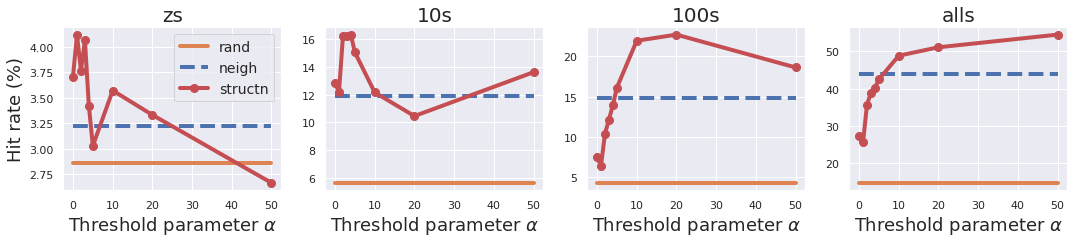

In [7]:
fig = plt.figure(figsize=(18, 3))

for split_id, split in enumerate(hit_rates):
    fig.add_subplot(1, 4, split_id + 1)
    for method in hit_rates[split]:
        y = []
        for alpha in alphas:
            if alpha not in hit_rates[split][method]:
                assert len(hit_rates[split][method]) == 1, list(hit_rates[split][method].keys())
                y.append(np.mean(hit_rates[split][method][alphas[0]]))
            else:
                y.append(np.mean(hit_rates[split][method][alpha]))
        
        plt.plot(alphas, np.array(y) * 100, 
                 '--' if method == 'neigh' else ('-o' if method == 'structn' else '-'), 
                 lw=4, 
                 color=colors[0 if method == 'neigh' else (1 if method == 'rand' else 3)], 
                 ms=8,
                 label=method)
    
    plt.title(split, fontsize=20)
    plt.xlabel(r'Threshold parameter $\alpha$', fontsize=18)
    
    if split_id == 0:
        plt.legend(fontsize=14)
        plt.ylabel('Hit rate (%)', fontsize=18)
    
    plt.grid(True)
plt.show()

## Generate "BERT score versus $\alpha$" plots similar to Figure 9 in the paper

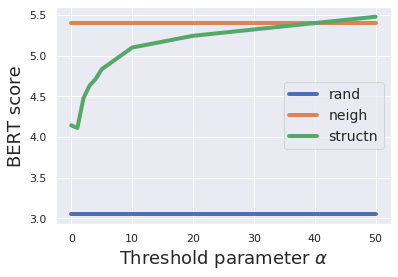

In [9]:
for method in bert_scores:
    y = []
    for alpha in alphas:
        if alpha not in hit_rates[split][method]:
            assert len(bert_scores[method]) == 1, list(bert_scores[method].keys())
            y.append(np.mean(bert_scores[method][alphas[0]]))
        else:
            y.append(np.mean(bert_scores[method][alpha]))
    plt.plot(alphas, y, lw=4, label=method)

plt.xlabel(r'Threshold parameter $\alpha$', fontsize=18)
plt.ylabel('BERT score', fontsize=18)
plt.legend(fontsize=14)    
plt.grid(True)
plt.show()    

In [10]:
print('done')

done
